# Calculating Cooling/Heating Degree Days using daily maximum & minimum temperature data from Cal-Adapt API

This notebook walks you through how we calculate Cooling and Heating Degree days for a county.

The daily maximum and minimum temperature datasets we will use in this exercise are raster datasets with a grid cell size of 1/16º (approximately 6 km). You can download data for an individual grid cell that corresponds to your area of interest or download data aggregated by a county boundary, watershed, etc. For a list of boundary layers supported by Cal-Adapt please see the API documentation. For this exercise we will get data for a county boundary.

In [1]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

----
## Step 1. Select location
----



#### To get data for a grid cell ...

In [2]:
point = 'POINT(-121.4687 38.5938)'

#### To get data for a user defined polygon ...

In [3]:
polygon = 'POLYGON ((-123.35449 39.09596, -122.27783 39.09596, -122.27783 39.97712, -123.35449 39.97712, -123.35449 39.09596))' 

#### To get data for a polygon using one of the boundary layers in Cal-Adapt API

Instead of passing raw geometry like we did earlier using the `g` parameter, you can use a polygon from boundary layers stored in the Cal-Adapt API. 

In [4]:
# Name of boundary layer in API (Counties)
resource = 'counties'

##### The `stat` parameter is used to spatially aggregate grid cell values. Accepted values are `mean`, `max`, `min`,  `median`, `sum`. If you don't provide the `stat` parameter, it defaults to mean

In [5]:
# url = api + '/' + resource + '/?intersects=' +  polygon + '&stat=max'

##### You need to know the `id` for this polygon/point and the boundary layer name. The cells below has code for doing this.

In [6]:
url = api + '/' + resource + '/?intersects=' +  point
response = requests.get(url)
county = response.json()
county = county['features'][0]
id  = county['id']
id

34

----
## Step 2. Download data
----

**Note: Requests might time out if the polygon is too large. If you need to process data for several boundaries we recommend downloading the daily rasters and processing the data locally.** 

Daily data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. Units for the observed data are degrees Celsius and projected data are in Kelvin.

The code in the next cell contains a bunch of functions to:
    - fetch daily data given an ID for polygon/point and query parameters
    - return a new Pandas dataframe with the daily data

In [7]:
def process_daily_data(slug):
    # Make request
    url = api + '/series/' + slug + '/events/?ref=/api/counties/%s/&imperial=TRUE&stat=mean' % id
    response = requests.get(url)
    df = None
    
    # Get data
    if response.ok:
        data = response.json()
        df = pd.DataFrame(data['data'], data['index']) 
        df.index.name = 'Date/Time'
        df.index = pd.to_datetime(df.index)
        df['climvar'] = data['name']
        df.columns = ['data', 'climvar']
        
    else:
        print('Failed to download:', slug)      
    # Combine all the dataframes into one and return
    return df

### Get observed historical data for maximum and minimum daily temperatures

In [8]:
def get_observed():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['tasmax', 'tasmin']
    period = ['day']
    zipped = itertools.product(climvar, period, ['livneh'])

    # Loop through zipped
    for item in zipped:
        slug = ('_').join(item)
        df = process_daily_data(slug)
        df_list.append(df)
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [9]:
observedDF = get_observed()
observedDF

,data,climvar
Date/Time,,
1950-01-01 00:00:00+00:00,47.758720,tasmax_day_livneh
1950-01-02 00:00:00+00:00,43.608700,tasmax_day_livneh
1950-01-03 00:00:00+00:00,46.929237,tasmax_day_livneh
1950-01-04 00:00:00+00:00,43.691647,tasmax_day_livneh
1950-01-05 00:00:00+00:00,45.237606,tasmax_day_livneh
1950-01-06 00:00:00+00:00,48.362000,tasmax_day_livneh
1950-01-07 00:00:00+00:00,50.520329,tasmax_day_livneh
1950-01-08 00:00:00+00:00,50.659874,tasmax_day_livneh
1950-01-09 00:00:00+00:00,50.557072,tasmax_day_livneh


### Download projected maximum and minimum daily temperatures for a model

In [10]:
def get_model(name):
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['tasmax', 'tasmin']
    period = ['day']
    models = [name]
    scenarios = ['rcp45', 'historical']
    zipped = itertools.product(climvar, period, models, scenarios)

    # Loop through zipped
    for item in zipped:
        slug = ('_').join(item)
        df = process_daily_data(slug)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [11]:
projectedDF = get_model('HadGEM2-ES')
projectedDF

,data,climvar
Date/Time,,
2006-01-01 00:00:00+00:00,48.327606,tasmax_day_HadGEM2-ES_rcp45
2006-01-02 00:00:00+00:00,43.412270,tasmax_day_HadGEM2-ES_rcp45
2006-01-03 00:00:00+00:00,37.300518,tasmax_day_HadGEM2-ES_rcp45
2006-01-04 00:00:00+00:00,42.419598,tasmax_day_HadGEM2-ES_rcp45
2006-01-05 00:00:00+00:00,46.024597,tasmax_day_HadGEM2-ES_rcp45
2006-01-06 00:00:00+00:00,44.538643,tasmax_day_HadGEM2-ES_rcp45
2006-01-07 00:00:00+00:00,48.801773,tasmax_day_HadGEM2-ES_rcp45
2006-01-08 00:00:00+00:00,46.930748,tasmax_day_HadGEM2-ES_rcp45
2006-01-09 00:00:00+00:00,53.686352,tasmax_day_HadGEM2-ES_rcp45


## 3.  Calculate Degree Days

In [12]:
base_temp = 65

# Calculate average of tasmax & tasmin for each day
observedAvg = observedDF.groupby(observedDF.index).mean()
projectedAvg = projectedDF.groupby(projectedDF.index).mean()

### Heating Degree Days

In [13]:
def calculate_hdd(df, base):
    # Find days with average temperature below base temperature
    dfHDD = pd.DataFrame(df.loc[df['data'] < base])
    # Calculate absolute value of difference between average temperature & base temperature
    dfHDD['data'] = abs(dfHDD['data'] - base)
    # Sum total number of heating degrees by year
    dfHDD = dfHDD.data.resample('1AS').sum()
    return dfHDD

In [14]:
# Get total number of heating degree days
observedHDD = calculate_hdd(observedAvg, base_temp)
observedHDD

Date/Time
1950-01-01 00:00:00+00:00    2554.938541
1951-01-01 00:00:00+00:00    2761.498083
1952-01-01 00:00:00+00:00    2902.806663
1953-01-01 00:00:00+00:00    2671.888463
1954-01-01 00:00:00+00:00    2845.844511
1955-01-01 00:00:00+00:00    2929.885815
1956-01-01 00:00:00+00:00    2775.846377
1957-01-01 00:00:00+00:00    2734.164612
1958-01-01 00:00:00+00:00    2329.074296
1959-01-01 00:00:00+00:00    2242.492341
1960-01-01 00:00:00+00:00    2634.636917
1961-01-01 00:00:00+00:00    2921.966697
1962-01-01 00:00:00+00:00    2888.671773
1963-01-01 00:00:00+00:00    3065.190241
1964-01-01 00:00:00+00:00    2795.360207
1965-01-01 00:00:00+00:00    2800.519259
1966-01-01 00:00:00+00:00    2461.409257
1967-01-01 00:00:00+00:00    2947.045529
1968-01-01 00:00:00+00:00    2613.466191
1969-01-01 00:00:00+00:00    2700.856404
1970-01-01 00:00:00+00:00    2464.259173
1971-01-01 00:00:00+00:00    3175.541558
1972-01-01 00:00:00+00:00    2916.337201
1973-01-01 00:00:00+00:00    2594.940887
1974-0

In [15]:
# Get total number of heating degree days
projectedHDD = calculate_hdd(projectedAvg, base_temp)
projectedHDD

Date/Time
1950-01-01 00:00:00+00:00    2744.523771
1951-01-01 00:00:00+00:00    2503.508440
1952-01-01 00:00:00+00:00    2505.933588
1953-01-01 00:00:00+00:00    2295.510742
1954-01-01 00:00:00+00:00    2389.827935
1955-01-01 00:00:00+00:00    2650.442411
1956-01-01 00:00:00+00:00    2505.259167
1957-01-01 00:00:00+00:00    2612.427208
1958-01-01 00:00:00+00:00    2607.766012
1959-01-01 00:00:00+00:00    2919.326442
1960-01-01 00:00:00+00:00    2448.597616
1961-01-01 00:00:00+00:00    2563.929442
1962-01-01 00:00:00+00:00    2593.669070
1963-01-01 00:00:00+00:00    3012.854207
1964-01-01 00:00:00+00:00    2865.907864
1965-01-01 00:00:00+00:00    2412.076344
1966-01-01 00:00:00+00:00    2381.562177
1967-01-01 00:00:00+00:00    2919.255974
1968-01-01 00:00:00+00:00    2628.994558
1969-01-01 00:00:00+00:00    2530.478220
1970-01-01 00:00:00+00:00    2352.854382
1971-01-01 00:00:00+00:00    2612.147624
1972-01-01 00:00:00+00:00    2266.178809
1973-01-01 00:00:00+00:00    2459.876146
1974-0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.01, 'Heating Degree Days')

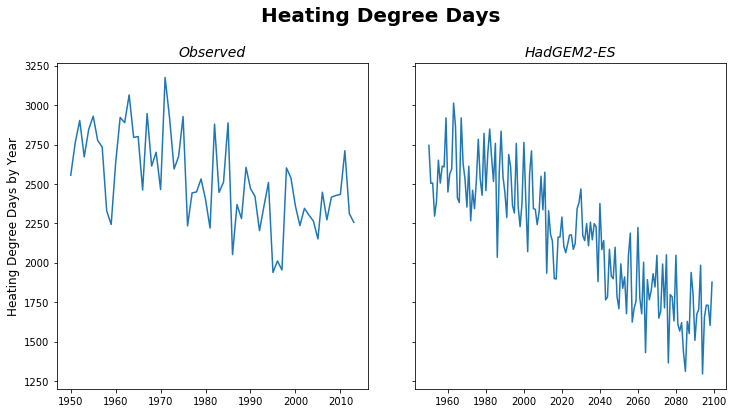

In [16]:
# Plot the data
f, (ax1, ax2) = plt.subplots(1, 2, sharey='all', figsize=(12, 6))

l1 = ax1.plot(observedHDD)
ax2.plot(projectedHDD)

ax1.set_title('Observed', fontstyle='italic', fontsize=14)
ax1.set_ylabel('Heating Degree Days by Year', fontsize=12)
ax2.set_title('HadGEM2-ES', fontstyle='italic', fontsize=14)

plt.subplots_adjust(wspace=0.15)

f.suptitle('Heating Degree Days', y=1.01, fontsize=20, fontweight='bold')

### Cooling Degree Days

In [17]:
def calculate_cdd(df, base):
    # Find days with average temperature above base temperature
    dfCDD = pd.DataFrame(df.loc[df['data'] > base])
    # Calculate absolute value of difference between average temperature & base temperature
    dfCDD['data'] = abs(dfCDD['data'] - base)
    # Sum total number of cooling degrees by year
    dfCDD = dfCDD.data.resample('1AS').sum()
    return dfCDD

In [18]:
# Get total number of heating degree days
observedCDD = calculate_cdd(observedAvg, base_temp)
observedCDD

Date/Time
1950-01-01 00:00:00+00:00    1219.390043
1951-01-01 00:00:00+00:00    1015.202103
1952-01-01 00:00:00+00:00    1141.821419
1953-01-01 00:00:00+00:00     978.358648
1954-01-01 00:00:00+00:00     930.043739
1955-01-01 00:00:00+00:00    1028.081129
1956-01-01 00:00:00+00:00    1026.406168
1957-01-01 00:00:00+00:00    1106.950319
1958-01-01 00:00:00+00:00    1325.518778
1959-01-01 00:00:00+00:00    1224.489859
1960-01-01 00:00:00+00:00    1275.167885
1961-01-01 00:00:00+00:00    1318.763178
1962-01-01 00:00:00+00:00     971.166401
1963-01-01 00:00:00+00:00     978.504192
1964-01-01 00:00:00+00:00    1027.190945
1965-01-01 00:00:00+00:00     923.651918
1966-01-01 00:00:00+00:00    1221.533657
1967-01-01 00:00:00+00:00    1415.469803
1968-01-01 00:00:00+00:00    1142.509924
1969-01-01 00:00:00+00:00    1249.515167
1970-01-01 00:00:00+00:00    1224.801327
1971-01-01 00:00:00+00:00    1180.537827
1972-01-01 00:00:00+00:00    1163.273758
1973-01-01 00:00:00+00:00    1235.186085
1974-0

In [19]:
# Get total number of heating degree days
projectedCDD = calculate_cdd(projectedAvg, base_temp)
projectedCDD

Date/Time
1950-01-01 00:00:00+00:00    1185.059965
1951-01-01 00:00:00+00:00    1373.574879
1952-01-01 00:00:00+00:00    1379.176813
1953-01-01 00:00:00+00:00    1390.213230
1954-01-01 00:00:00+00:00     963.462200
1955-01-01 00:00:00+00:00    1015.719831
1956-01-01 00:00:00+00:00    1198.536039
1957-01-01 00:00:00+00:00    1483.043846
1958-01-01 00:00:00+00:00    1250.174614
1959-01-01 00:00:00+00:00    1339.055811
1960-01-01 00:00:00+00:00    1374.798779
1961-01-01 00:00:00+00:00    1398.041515
1962-01-01 00:00:00+00:00    1078.628954
1963-01-01 00:00:00+00:00     969.731981
1964-01-01 00:00:00+00:00    1296.613825
1965-01-01 00:00:00+00:00    1286.633860
1966-01-01 00:00:00+00:00    1461.277468
1967-01-01 00:00:00+00:00    1208.062326
1968-01-01 00:00:00+00:00    1360.535862
1969-01-01 00:00:00+00:00    1373.123255
1970-01-01 00:00:00+00:00    1267.065767
1971-01-01 00:00:00+00:00    1173.428473
1972-01-01 00:00:00+00:00    1427.270901
1973-01-01 00:00:00+00:00    1482.936495
1974-0

Text(0.5, 1.01, 'Cooling Degree Days')

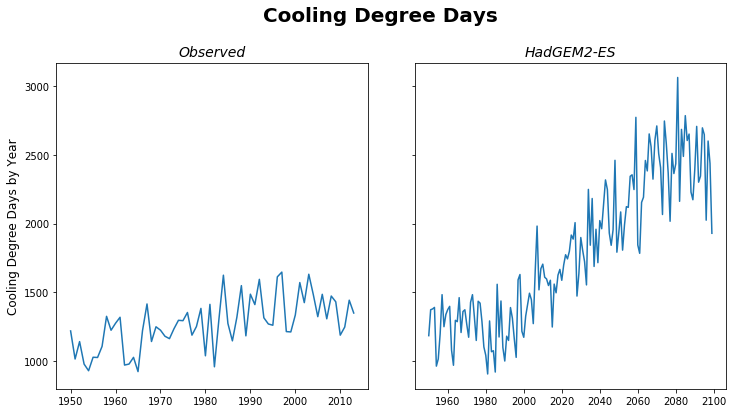

In [20]:
# Plot the data
f, (ax1, ax2) = plt.subplots(1, 2, sharey='all', figsize=(12, 6))

l1 = ax1.plot(observedCDD)
ax2.plot(projectedCDD)

ax1.set_title('Observed', fontstyle='italic', fontsize=14)
ax1.set_ylabel('Cooling Degree Days by Year', fontsize=12)
ax2.set_title('HadGEM2-ES', fontstyle='italic', fontsize=14)

plt.subplots_adjust(wspace=0.15)

f.suptitle('Cooling Degree Days', y=1.01, fontsize=20, fontweight='bold')